## Dataset: Yelp review data

Download the training_data.json file, a collection of 40,000 json-encoded Yelp reviews we sampled from the [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge).

Each line corresponds to a review on a particular business. The label (class) information of each review is in the "label" field. It is **either "Food-relevant" or "Food-irrelevant"**.

In [6]:
# Using jsonlines library. Data Format: one valid json per line
import jsonlines
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [2]:
# Read the training_data file
review_list = []
label_list = []
with jsonlines.open('training_data.json') as reader:
    for json_obj in reader:
        review_list.append(json_obj["text"])
        label_list.append(json_obj["label"])

review_df = pd.DataFrame({'text': review_list, 
                         'label': label_list})

In [3]:
review_df.head(10)

,label,text
0,Food-irrelevant,dr. goldberg offers everything i look for in a...
1,Food-irrelevant,"Unfortunately, the frustration of being Dr. Go..."
2,Food-irrelevant,Dr. Goldberg has been my doctor for years and ...
3,Food-irrelevant,Been going to Dr. Goldberg for over 10 years. ...
4,Food-irrelevant,Got a letter in the mail last week that said D...
5,Food-irrelevant,I don't know what Dr. Goldberg was like before...
6,Food-irrelevant,Top notch doctor in a top notch practice. Can'...
7,Food-irrelevant,Dr. Eric Goldberg is a fantastic doctor who ha...
8,Food-relevant,Pretty good dinner with a nice selection of fo...
9,Food-relevant,Good truck stop dining at the right price. We ...


In [4]:
type(review_df['label'][0])

unicode

In [5]:
review_df['isFoodRelevant'] = review_df['label'].apply(lambda label: 1 if label == u'Food-relevant' else 0)
review_df.head(10)

,label,text,isFoodRelevant
0,Food-irrelevant,dr. goldberg offers everything i look for in a...,0
1,Food-irrelevant,"Unfortunately, the frustration of being Dr. Go...",0
2,Food-irrelevant,Dr. Goldberg has been my doctor for years and ...,0
3,Food-irrelevant,Been going to Dr. Goldberg for over 10 years. ...,0
4,Food-irrelevant,Got a letter in the mail last week that said D...,0
5,Food-irrelevant,I don't know what Dr. Goldberg was like before...,0
6,Food-irrelevant,Top notch doctor in a top notch practice. Can'...,0
7,Food-irrelevant,Dr. Eric Goldberg is a fantastic doctor who ha...,0
8,Food-relevant,Pretty good dinner with a nice selection of fo...,1
9,Food-relevant,Good truck stop dining at the right price. We ...,1


In [8]:
import string
from nltk.stem.porter import *
import re

stemmer = PorterStemmer()
# Returns a review after stemming, casefolding, removing punctuation
def preprocess_text(review):
    # Replaces every punctuation with a whitespace
    #replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    word_list = []
    
    #This for loop turns the text into lower case, splits the text on punctuations and white spaces
    # followed by applying Porter stemmer on each word.
    text = re.split('\W+', review.lower())
    for word in text:
        word = stemmer.stem(word)
        word_list.append(word)
    return ' '.join(word_list)

In [7]:
review_df['review_clean'] = review_df['text'].apply(preprocess_text)
review_df.head(3)
%store review_df

Stored 'review_df' (DataFrame)


In [2]:
%store -r review_df

### Unique tokens?
Size of your feature space. That is, how many unique tokens are present?

In [6]:
count_vect = CountVectorizer(token_pattern=r'\b\w+\b')
review_matrix = count_vect.fit_transform(review_df['review_clean'])
%store review_matrix

Stored 'review_matrix' (csr_matrix)


In [9]:
word_dict= count_vect.vocabulary_

n = len(word_dict)
print 'Unique word count is: ', n

Unique word count is:  36555


### The Most Popular Words

Great, now we can tokenize the documents. Let's make a list of the most popular words in our reviews. For this step, you should maintain a count of how many times each word occurs. Then print out the top-20 words in your reviews.

Output should look like this:

Rank Token Count

1 awesome 78

... ...

In [10]:
unique_words_count = review_matrix.sum(axis=0)
words_freq = [(word, unique_words_count[0, idx]) for word, idx in count_vect.vocabulary_.items()]
sorted_word_dict = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [11]:
rank = 1
for word, count in sorted_word_dict[:20]:
    print rank, "\t", word, "\t", count
    rank = rank + 1

1 	the 	246309
2 	i 	168931
3 	and 	168589
4 	a 	134904
5 	to 	128139
6 	it 	78867
7 	of 	76237
8 	wa 	74020
9 	is 	63496
10 	for 	60867
11 	in 	60523
12 	that 	50804
13 	my 	50565
14 	you 	45881
15 	they 	43635
16 	thi 	39940
17 	with 	39340
18 	have 	39082
19 	but 	37967
20 	on 	35388


### Zipf's Law

Let's see if this law applies to our Yelp reviews. Using matplotlib to plot the log-base10 term counts on the y-axis versus the log-base10 rank on the x-axis. 

In [12]:
rank_count_dict = {}
count = 1
for k,v in sorted_word_dict:
    rank_count_dict[count] = v
    count += 1

rank_count_dict

{1: 246309,
 2: 168931,
 3: 168589,
 4: 134904,
 5: 128139,
 6: 78867,
 7: 76237,
 8: 74020,
 9: 63496,
 10: 60867,
 11: 60523,
 12: 50804,
 13: 50565,
 14: 45881,
 15: 43635,
 16: 39940,
 17: 39340,
 18: 39082,
 19: 37967,
 20: 35388,
 21: 34969,
 22: 34289,
 23: 31608,
 24: 29853,
 25: 27347,


Text(0,0.5,u'log10 (count)')

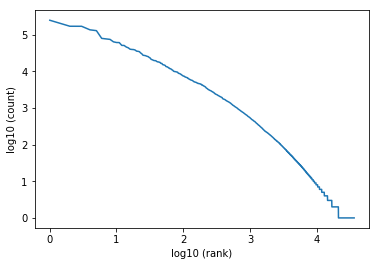

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log
x = [log(e,10) for e in rank_count_dict.keys()]
y = [log(e,10) for e in rank_count_dict.values()]

plt.plot(x,y)
plt.xlabel('log10 (rank)')
plt.ylabel('log10 (count)')

Zipf's law states that the frequency of any word is inversely proportional to its rank in the frequency table. 

Our graph plotted above is consistent with the Zipf's law. Initial set of words with very high frequency are useless in our text analysis. As can be seen above (in top20 words section), these words are mostly stop words. As the rank of the words in increasing, the corresponding frequency of the word is decreasing.


## Feature Represenation

In this part  build feature vectors for each review. This will be input to our ML classifiers. Call parser from earlier, using all the same assumptions (e.g., casefolding, stemming). Each feature value should be the term count for that review.

In [3]:
%store -r review_matrix

In [6]:
def prepare_data(dataframe):
    dataframe['review_clean'] = review_df['text'].apply(preprocess_text)

In [7]:
review_matrix.data[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1,
       2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 2, 1, 6, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2])

In [8]:
review_matrix.shape

(40000, 36555)

## Machine Learning Basics

In this par evaluate a bunch of classifiers -- kNN, Decision tree, Naive Bayes, and SVM -- on the feature vectors generated in the previous task in two different settings. 

### Setting 1: Splitting data into train-test 

In the first setting, treat the first 70% of your data as training. The remaining 30% should be for testing. 

### Setting 2: Using 5 fold cross-validation

In the second setting, use 5-folk cross-validation. 

### What to report

* Report the overall accuracy for both settings.
* For the class "Food-relevant", report the precision and recall for both settings.
* For the class "Food-irrelevant", report the precision and recall for both settings.

#### Setting 1 - Split data into 70:30 ratio

In [4]:
# TODO - Change to iloc to remove this deprecation warning
partition_index = int(len(review_df) * .7)

train_df = review_df.iloc[: partition_index] 
test_df = review_df.iloc[partition_index:]


print "Length of original data: ", len(review_df)
print "Length of training data: ", len(train_df)
print "Length of test data: ", len(test_df)

Length of original data:  40000
Length of training data:  28000
Length of test data:  12000


In [7]:
train_vectorizer = CountVectorizer(token_pattern = r'\b\w+\b')
train_review_matrix = train_vectorizer.fit_transform(train_df['review_clean'])
test_review_matrix = train_vectorizer.transform(test_df['review_clean'])

In [8]:
%store train_review_matrix
%store test_review_matrix
%store train_df
%store test_df

Stored 'train_review_matrix' (csr_matrix)
Stored 'test_review_matrix' (csr_matrix)
Stored 'train_df' (DataFrame)
Stored 'test_df' (DataFrame)


In [4]:
%store -r train_review_matrix
%store -r test_review_matrix
%store -r train_df
%store -r test_df

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def calculateMetrics(predicted_labels, true_labels):
    accuracy = accuracy_score(true_labels, predicted_labels, normalize=True)

    precision_food_relevant = precision_score(true_labels, predicted_labels, pos_label = 1)
    recall_food_relevant = recall_score(true_labels, predicted_labels, pos_label = 1)
    
    precision_food_irrelevant = precision_score(true_labels, predicted_labels, pos_label = 0)
    recall_food_irrelevant = recall_score(true_labels, predicted_labels, pos_label = 0)
   
    return accuracy, precision_food_relevant, recall_food_relevant, precision_food_irrelevant, recall_food_irrelevant

In [6]:
def print_metrics(metrics):
    metrics = [round(e, 5) for e in metrics] 
    print "Accuracy: ", metrics[0]
    print "Precision is ", metrics[1], " and recall is ", metrics[2], " for Food Relevant class"
    print "Precision is ", metrics[3] , " and recall is ", metrics[4], " for Food Irrelevant class"

#### Decision Tree Classifier

In [7]:
from sklearn import tree

def decision_tree_model(train_review_matrix, train_df, test_review_matrix, test_df):
    dt_clf = tree.DecisionTreeClassifier()
    dt_clf = dt_clf.fit(train_review_matrix, train_df['isFoodRelevant'])

    predicted_classes = dt_clf.predict(test_review_matrix)
    metrics = calculateMetrics(predicted_classes, test_df['isFoodRelevant'])
    return metrics, dt_clf

In [26]:
dt_metrics = decision_tree_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
print_metrics(dt_metrics)

Accuracy:  0.76517
Precision is  0.07428  and recall is  0.94142  for Food Relevant class
Precision is  0.99844  and recall is  0.76158  for Food Irrelevant class


#### Naive Bayes Classifier

In [8]:
from sklearn.naive_bayes import MultinomialNB
def naive_bayes_model(train_review_matrix, train_df, test_review_matrix, test_df):
    clf = MultinomialNB().fit(train_review_matrix, train_df['isFoodRelevant'])

    predicted_classes = clf.predict(test_review_matrix)
    return calculateMetrics(predicted_classes, test_df['isFoodRelevant']), clf

In [28]:
nb_metrics = naive_bayes_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
print_metrics(nb_metrics)

Accuracy:  0.93717
Precision is  0.23805  and recall is  0.97908  for Food Relevant class
Precision is  0.99955  and recall is  0.93631  for Food Irrelevant class


#### SVM Classifier

In [9]:
from sklearn import svm

def svm_model(train_review_matrix, train_df, test_review_matrix, test_df):
    svm_clf = svm.LinearSVC().fit(train_review_matrix, train_df['isFoodRelevant'])
    predicted_classes = svm_clf.predict(test_review_matrix)
    return calculateMetrics(predicted_classes, test_df['isFoodRelevant']), svm_clf

In [30]:
svm_metrics = svm_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
print_metrics(svm_metrics)

Accuracy:  0.861
Precision is  0.12256  and recall is  0.97071  for Food Relevant class
Precision is  0.99931  and recall is  0.85877  for Food Irrelevant class


#### Random Forest Classifier (Not able to run KNN Classifier)

In [10]:
def rf_model(train_review_matrix, train_df, test_review_matrix, test_df):
    rf_clf = RandomForestClassifier()
    rf_clf.fit(train_review_matrix, train_df['isFoodRelevant'])
    predicted_classes = rf_clf.predict(test_review_matrix)
    return calculateMetrics(predicted_classes, test_df['isFoodRelevant']), rf_clf

In [91]:
rf_metrics = rf_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
print_metrics(rf_metrics)

Accuracy:  0.78475
Precision is  0.08381  and recall is  0.98745  for Food Relevant class
Precision is  0.99967  and recall is  0.78063  for Food Irrelevant class


#### Setting 2: Cross Validation 

In [11]:
def get_train_test_matrices(train_indices, test_indices, train_df, test_df):
    train_vectorizer2 = CountVectorizer(token_pattern = r'\b\w+\b')
    train_review_matrix = train_vectorizer2.fit_transform(train_df['review_clean'])
    test_review_matrix = train_vectorizer2.transform(test_df['review_clean'])
    return train_review_matrix, test_review_matrix

In [12]:
def calculate_avg_metrics(metrics, model_index):
    accurracy_avg = sum([tuple[0] for tuple in metrics[model_index]])/5
    precision_food_relevant_avg = sum([tuple[1] for tuple in metrics[model_index]])/5
    recall_food_relevant_avg = sum([tuple[2] for tuple in metrics[model_index]])/5
    precision_food_irrelevant_avg = sum([tuple[3] for tuple in metrics[model_index]])/5
    recall_food_irrelevant_avg = sum([tuple[4] for tuple in metrics[model_index]])/5
    avg_metrics = (accurracy_avg, precision_food_relevant_avg, recall_food_relevant_avg, precision_food_irrelevant_avg, recall_food_irrelevant_avg)
    print_metrics(avg_metrics)

In [13]:
def analyse_kfold_data(metrics):
    print "Decision Tree Model:"
    calculate_avg_metrics(metrics, 0)
    print ""
    print "Naive Bayes Model"
    calculate_avg_metrics(metrics, 1)
    print ""
    print "SVM"
    calculate_avg_metrics(metrics, 2)
    print ""
    print "Random forest"
    calculate_avg_metrics(metrics, 3)

In [95]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5)

m, itr = 4, 5 

kfold_metrics = [[0 for x in range(itr)] for y in range(m)]
idx = 0
for train_indices, test_indices in kf.split(review_df):
    train_df = review_df.iloc[train_indices]
    test_df = review_df.iloc[test_indices]
    train_review_matrix, test_review_matrix = get_train_test_matrices(train_indices, test_indices, train_df, test_df)
    kfold_metrics[0][idx] = decision_tree_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    kfold_metrics[1][idx] = naive_bayes_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    kfold_metrics[2][idx] = svm_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    kfold_metrics[3][idx] = rf_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    idx = idx + 1

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [98]:
analyse_kfold_data(kfold_metrics)

Decision Tree Model:
Accuracy:  0.8566
Precision is  0.73125  and recall is  0.68607  for Food Relevant class
Precision is  0.81424  and recall is  0.8633  for Food Irrelevant class

Naive Bayes Model
Accuracy:  0.93578
Precision is  0.7591  and recall is  0.75242  for Food Relevant class
Precision is  0.90816  and recall is  0.92092  for Food Irrelevant class

SVM
Accuracy:  0.91062
Precision is  0.75654  and recall is  0.72685  for Food Relevant class
Precision is  0.87042  and recall is  0.91541  for Food Irrelevant class

Random forest
Accuracy:  0.8728
Precision is  0.76162  and recall is  0.66994  for Food Relevant class
Precision is  0.8046  and recall is  0.92082  for Food Irrelevant class


## Part 1.5: Improving  classifier 

I think we can do better!

In [17]:
# Trying TFidf Transformer
from sklearn.feature_extraction.text import TfidfVectorizer

def get_train_test_matrices_v2(train_indices, test_indices, train_df, test_df):
    tfidf_vectoriser = TfidfVectorizer(token_pattern = r'\b\w\w\w+\b', stop_words='english')
    train_review_matrix = tfidf_vectoriser.fit_transform(train_df['review_clean'])
    test_review_matrix = tfidf_vectoriser.transform(test_df['review_clean'])
    return train_review_matrix, test_review_matrix

In [18]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5)

m, itr = 4, 5 

kfold_metrics = [[0 for x in range(itr)] for y in range(m)]
idx = 0
for train_indices, test_indices in kf.split(review_df):
    train_df = review_df.iloc[train_indices]
    test_df = review_df.iloc[test_indices]
    train_review_matrix, test_review_matrix = get_train_test_matrices_v2(train_indices, test_indices, train_df, test_df)
    kfold_metrics[0][idx] = decision_tree_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    kfold_metrics[1][idx] = naive_bayes_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    kfold_metrics[2][idx] = svm_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    kfold_metrics[3][idx] = rf_model(train_review_matrix, train_df, test_review_matrix, test_df)[0]
    idx = idx + 1
    
analyse_kfold_data(kfold_metrics)    

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Decision Tree Model:
Accuracy:  0.8677
Precision is  0.73749  and recall is  0.69792  for Food Relevant class
Precision is  0.82902  and recall is  0.87058  for Food Irrelevant class

Naive Bayes Model
Accuracy:  0.91895
Precision is  0.76601  and recall is  0.73799  for Food Relevant class
Precision is  0.88303  and recall is  0.92748  for Food Irrelevant class

SVM
Accuracy:  0.93345
Precision is  0.77229  and recall is  0.7375  for Food Relevant class
Precision is  0.88769  and recall is  0.94656  for Food Irrelevant class

Random forest
Accuracy:  0.89355
Precision is  0.76327  and recall is  0.69638  for Food Relevant class
Precision is  0.8334  and recall is  0.92411  for Food Irrelevant class


### In the above approach, I am removing all the standard stop words in the English dictionary from the review text. Also, I am removing any word that has length less than 3 from the reviews. Following that, I am using Tf-idf scoring criteria for feature space.

If we only compare the accuracy of this Tf-idf model with the vanilla term-frequency model, there hasn't been much change in the accuracy from one model to other.

However, the there is improvement in the precision of Food-Relevant label from ~75% to ~77%. This is good improvement.


### 2) Using Bi-gram language model with svm 

In [115]:
bigram_vectoriser = CountVectorizer(ngram_range=(1,2), token_pattern = r'\b\w\w\w+\b', stop_words='english')
train_bigram_matrix = bigram_vectoriser.fit_transform(train_df["review_clean"])
test_bigram_matrix = bigram_vectoriser.transform(test_df["review_clean"])
%store bigram_vectoriser
%store train_bigram_matrix
%store test_bigram_matrix

Stored 'bigram_vectoriser' (CountVectorizer)
Stored 'train_bigram_matrix' (csr_matrix)
Stored 'test_bigram_matrix' (csr_matrix)


In [117]:
bigram_vectoriser.vocabulary_

{u'south road': 720904,
 u'includ yelp': 390221,
 u'honest someth': 372738,
 u'case involv': 124992,
 u'contemporari rust': 172617,
 u'filet fix': 292768,
 u'pastrami virgin': 555082,
 u'includ doubl': 389644,
 u'haven chees': 359027,
 u'huge fanfar': 381328,
 u'hope beef': 374067,
 u'lot potenti': 455348,
 u'thing besid': 782607,
 u'theme peta': 778782,
 u'happier couldn': 356470,
 u'beauti gurgl': 69001,
 u'person add': 564347,
 u'gone won': 331875,
 u'middl stage': 488090,
 u'overcharg fifti': 543176,
 u'came helper': 117748,
 u'bar byron': 61519,
 u'burro total': 110981,
 u'inexpens delici': 392342,
 u'piec look': 571754,
 u'reflect littl': 626839,
 u'combin mexican': 159842,
 u'passion thi': 553910,
 u'possibl disgust': 588977,
 u'plu tri': 583484,
 u'ars littl': 42584,
 u'dri rib': 239358,
 u'place shadi': 577274,
 u'dancer like': 197624,
 u'sonic great': 717362,
 u'purchas thought': 607880,
 u'trojan': 810460,
 u'wine pitcher': 863880,
 u'strike food': 746536,
 u'fact chicago': 

In [119]:
naive_bayes_result = naive_bayes_model(train_bigram_matrix, train_df, test_bigram_matrix, test_df)
nb_metrics = naive_bayes_result[0]
nb_bigram_model = naive_bayes_result[1]
print_metrics(nb_metrics)

Accuracy:  0.9245
Precision is  0.0  and recall is  0.0  for Food Relevant class
Precision is  1.0  and recall is  0.9245  for Food Irrelevant class


In [120]:
svm_result = svm_model(train_bigram_matrix, train_df, test_bigram_matrix, test_df)
svm_metrics = svm_result[0]
svm_bigram_model = svm_result[1]
print_metrics(svm_metrics)

Accuracy:  0.91887
Precision is  0.0  and recall is  0.0  for Food Relevant class
Precision is  1.0  and recall is  0.91887  for Food Irrelevant class


### In the above model, we are trying to create a model of bigrams using TF-idf score criteria. Although, the accuracy of the model is almost same as the previous model - ~92%, the precision of the model for Food-Relevant data is 0, which is not desirable. Therefore, we need to tinker more with this model to make it usable.

**Other possible changes to improve the model**

We can get the food related words from the wordnet database. Use those words in our dataset assigning them more weight, and then train our model.
This approach will lead to increase in our precison for food relevant data and also improve accuracy.

### This analysis is done on the data obtained from Scenario 1 ( 70:30 data split)
#### 1) Using chi-squared stats to select the best 10 features

In [54]:
from sklearn.feature_selection import chi2

chi2score = chi2(train_tfidf_matrix, train_df["isFoodRelevant"])[0]

In [56]:
wscores = zip(tfidf_vectoriser.get_feature_names(), chi2score)
top_chi_scores = sorted(wscores, key = lambda score: score[1], reverse = True)

In [57]:
top_chi_scores[:20]

[(u'food', 247.86341695810285),
 (u'car', 216.43206239117248),
 (u'zoo', 169.79510114756724),
 (u'exhibit', 164.57384069662658),
 (u'dr', 148.92894006448495),
 (u'hotel', 132.8543048433601),
 (u'wash', 119.96397070000924),
 (u'help', 119.54576501584486),
 (u'chicken', 118.39841654171589),
 (u'order', 116.36340838169082),
 (u'store', 113.95327200127554),
 (u'sandwich', 111.8770453089535),
 (u'repair', 108.27856431983842),
 (u'room', 107.85684986666467),
 (u'salon', 100.55230964550813),
 (u'lunch', 98.835295490317293),
 (u'appoint', 95.223255716213444),
 (u'menu', 95.102257119134464),
 (u'salad', 94.998212599730721),
 (u'delici', 93.619434154590948)]

#### Using chi2 score and tf-idf criteria, the most informative words in the model are food, car, zoo,exhibit, hotel, chicken and other features listed above

#### 2) Since the accuracy of SVM is the best among all the 4 classifiers used, we are using SVM coefficients to select the best features

In [79]:
features_names = tfidf_vectoriser.get_feature_names()
feature_scores = zip(features_names, svm_clf.coef_[0])
feature_scores_sorted = sorted(feature_scores, key = lambda x: x[1], reverse = True)
feature_scores_sorted[:20]

[(u'food', 5.6545514949900513),
 (u'walgreen', 3.6767937382963067),
 (u'sandwich', 3.3301366413290108),
 (u'eat', 3.1690883535734256),
 (u'costco', 3.1671206421533418),
 (u'groceri', 3.0855110245009549),
 (u'dine', 2.9106194049091836),
 (u'menu', 2.7139483467701049),
 (u'safeway', 2.5537099282064761),
 (u'produc', 2.5485950932757082),
 (u'wine', 2.5149116783688812),
 (u'order', 2.5099888579838501),
 (u'waiter', 2.4841887475464883),
 (u'restaur', 2.3880628110457427),
 (u'coffe', 2.3761644345899517),
 (u'starbuck', 2.3058105339204205),
 (u'chines', 2.2940349501068265),
 (u'bruschetta', 2.2766494285546086),
 (u'server', 2.2241605468262517),
 (u'bakeri', 2.147795214640976)]

#### The top 20 features as given by the SVM are listed above. {food, walgreen, sandwich, eat, costco and others}

#### These features look more relevant (food related) as compared to the features obtained by the chi2 criteria